In [1]:
%matplotlib inline

import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;
#import bqplot.pyplot as plt;

import random;
import os;
import re;

In [2]:
att = r'C:\Users\custjo01\Documents\WPS Workspaces\mainWorkspace\attributes_final_IMS.txt';
att = pd.read_csv(att, sep=';');

In [3]:
att=att[att.II_SPECIALTY_CD_1=="C_4_01"]
att.drop([c for c in att.columns if re.match("(.*_RJ|.*_PD)$|ITE|BIL",c)], axis=1, inplace=True)
att.head()

,II_SPECIALTY_CD_1,II_RENDERING_PROVIDER_KEY,DAY_CH,CLM_CH,PAT_CH,PAT_DAY_CH,AMT_CH,UOS_CH,UOS_CH_ELC,UOS_CH_ERC,...,PCT_DIFFDAYPAT,PCT_HOSP_PROC_SIZE_THREE,UOS_CH_DAYIC__UOS_CH_FEEICU,UOS_PD_DAYIC__UOS_PD_FEEICU,AMT_CH_FEEICU__UOS_CH_FEEICU,AMT_PD_FEEICU__UOS_PD_FEEICU,UOS_PD_FEEICU__UOS_PD_DAYIC,UOS_CH_FEEICU__UOS_CH_DAYIC,AMT_PD_DAYIC__AMT_PD_DAYTOT,UOS_PD_DAYIC__UOS_PD_DAYTOT
13101,C_4_01,10022_C_4_01,297.0,3559.0,1068.0,2612.0,1055597.32,18106.0,1.0,3559.0,...,0.5187,0.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13102,C_4_01,100504_C_4_01,1.0,1.0,1.0,1.0,124.12,2.0,0.0,1.0,...,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13103,C_4_01,10634_C_4_01,68.0,90.0,38.0,82.0,41862.72,884.0,0.0,90.0,...,0.5789,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13104,C_4_01,11447_C_4_01,1.0,1.0,1.0,1.0,83.88,2.0,0.0,1.0,...,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13105,C_4_01,11523_C_4_01,3.0,3.0,2.0,3.0,626.85,8.0,0.0,3.0,...,0.5000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [364]:
def testNan(col):
    v = att[col].values;
    f = float(np.sum(np.isnan(v)));
    if f == 0:
        return 0;
    return float(len(v))/f;
numericCols = sorted(att.select_dtypes(include=[np.number]).columns.tolist());
nanCols = [c for c in numericCols if testNan(c) > 0.1 ]
att.drop(columns=nanCols, inplace=True)

In [365]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ipywidgets import FloatSlider, IntSlider, IntRangeSlider,Accordion, VBox, Dropdown

In [366]:
def getCumPer(x, cumPerCut = 0.2):
    t = np.sort(x).cumsum();
    t /=t.max();
    count = np.sum(t < cumPerCut);
    
    return int(count/len(t) *100)

In [367]:
def getLimits(a):
    a = a[~np.isnan(a)]
    i = a.min();
    e = a.max();
    r = e - i;
    return (i - r*0.05, e +r*0.05)

In [368]:
def getColor(x,y,xcut,ycut):
    if x < xcut:
        return 'gray' if y < ycut  else 'green';
    else:
        return 'orange' if y < ycut  else 'red';

In [369]:
numericCols = sorted(att.select_dtypes(include=[np.number]).columns.tolist());
def rejected(c):
    for s in ['_PD_','BIL','DAYIC','FEEICU','DAYFEE','ELC','_RJ','__HOSPDAY','HOSPVST']:
        if s in c:
            return True;
    return  False;
numericCols= [c for c in numericCols if not rejected(c)]

numericCols = [''] + [ c  for c in numericCols if testNan(c)<0.1]

#numericCols

In [380]:
def plot(x, y, size, mass, xcut, ycut, xRange, yRange):
    if x == '' or y == '':
        return;
    xtitle = x;
    ytitle = y;
    x = att[x].values.copy();
    y = att[y].values.copy();
    if size == '':
        z = np.ones(len(x))/100.0;
        filtermap = np.ones(len(x)) == 1;
    else:
        z = att[size].values.copy();
        filtermap = z > np.percentile(z,q=mass);
        
    x = x[filtermap]; y = y[filtermap]; z = z[filtermap];

    y[np.isnan(y)] = 0;x[np.isnan(x)] = 0;
    if not size == '':
        z = (z - x.min())/(z.max() - z.min());

    ycutLabel = "%s"%ycut;
    xcutLabel = "%s"%xcut;
    xcut = np.percentile(x,q=xcut);
    ycut = np.percentile(y,q=ycut);

    x = np.clip(x,a_min=np.percentile(x,q=xRange[0]), a_max=np.percentile(x,q=xRange[1]))
    y = np.clip(y,a_min=np.percentile(y,q=yRange[0]), a_max=np.percentile(y,q=yRange[1]))

    ccolors = [getColor(x1,y1,xcut,ycut)    for x1,y1 in zip(x,y)]
 

    xlim = getLimits(x);
    ylim = getLimits(y);

    plt.figure(figsize=(7,7));
    plt.xlim(*xlim);
    plt.ylim(*ylim);
    plt.hlines(y=ycut, xmin=xlim[0], xmax=xlim[1], linewidth=2,linestyles=':', color='#000000')
    plt.annotate(ycutLabel, xy=(xlim[1],ycut))
    plt.vlines(x=xcut, ymin=ylim[0], ymax=ylim[1], linewidth=2,linestyles=':', color='#000000')
    plt.annotate(xcutLabel, xy=(xcut,ylim[1]))
    plt.xlabel(xtitle);
    plt.ylabel(ytitle);
    plt.scatter(x, y, c=ccolors, s=z*5000+10, alpha=0.4);
    
    keys = att.II_RENDERING_PROVIDER_KEY.values[filtermap];
    redAtt = att[att.II_RENDERING_PROVIDER_KEY.isin(keys)];
    redAtt = redAtt.loc[np.array(ccolors)=='red'];
    if not size == '':
        redAtt = redAtt.sort_values(size, ascending =False)
    display(redAtt.head(5))    
    


In [392]:
def createIntRange(desc):
    return IntRangeSlider(min=0,max=100,value=[1, 100],step=1,continuous_update=False,readout=True,description=desc)

xvar = Dropdown(description='x', options=numericCols);
xrange = createIntRange('Range:');

yvar = Dropdown(description='y', options=numericCols);
yrange = createIntRange('Range:');

zvar = Dropdown(description='size', options=numericCols);
zrange = IntSlider(min=0, max=100, step=5,value=0,continuous_update=False,description='Corte os % menores');

xcut = IntSlider(min=0, max=100, step=5,value=50,continuous_update=False,description='X');
ycut = IntSlider(min=0, max=100, step=5,value=50,continuous_update=False,description='Y');


c2 = widgets.HBox([xvar, xrange]);
c3 = widgets.HBox([yvar, yrange]);
c4 = widgets.HBox([zvar, zrange]);
c5 = widgets.HBox([xcut, ycut])

ui = widgets.Tab()
ui.children = [ widgets.VBox([c2,c3,c4]),  widgets.HBox([c5])]
ui.set_title(0, 'Eixos')
ui.set_title(1, 'Quadrantes')

comps ={
    'x': xvar,
    'y': yvar,
    'size':zvar,
    'mass':zrange ,
    'xcut':xcut,
    'ycut':ycut,
    'xRange':xrange,
    'yRange':yrange
}
out = widgets.interactive_output(plot, comps)
display(ui, out)

Output()

In [457]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [458]:
def mahalanobis(x):
    m = x.mean(axis=0)
    x2 = x - m;
    p = np.linalg.inv(np.cov(x2.T))
    m = np.sum(x2.dot(p)*x2, axis=1)
    return np.sqrt(m);

In [474]:
def scoring(method, ngroupsScore, x):    
    if method == 'Rank':
        score= x.prod(axis=1) ** (1/float(x.shape[1]));
        score = np.clip(np.ceil(ngroupsScore*score),a_min=1, a_max=10000000);
    elif method == 'Mahalanobis':
        score = mahalanobis(x);
        score = np.ceil(ngroupsScore*(score - score.min())/(score.max()-score.min()));
    elif method == 'KMeans':
        score = KMeans(n_clusters=ngroupsScore, random_state=0).fit(x).labels_
    elif method == 'AffinityPropagation':
        score = KMeans(n_clusters=ngroupsScore, random_state=0).fit(x).labels_
    else:
        score = AgglomerativeClustering(n_clusters=ngroupsScore).fit(x).labels_
    return score

In [486]:
def makePOI2(size, mass, ngroups,ngroupsScore, method, **xs):
    cmap = plt.cm.tab10;
    xvars = [v for v in xs.values() if  v != ''];
    if len(xvars) < 1:
        return;
    xs =[att[i].values.copy() for i in xvars];
    z = att[size].values.copy();

    countItems = len(z);
    filtermap = z >= np.percentile(z,q=mass);
    z = z[filtermap];   
    xs = [x[filtermap] for x in xs];
    
    for i in range(len(xs)):
        xs[i][np.isnan(xs[i])] = 0;
        
    px = np.vstack([np.argsort(x.argsort())/float(len(x)) for x in xs]).T;    
    
    score = scoring(method, ngroupsScore, px);
    
    finScore = np.argsort(z.argsort());
    finScore = np.ceil(ngroups*(finScore+1)/float(len(z)));
    
    df = {
        'score':score,
        'fin':finScore,
        'z':z
    };
    for i,x in enumerate(xvars):
        df[x]= xs[i];
    df = pd.DataFrame(df);
    
    plotsRows = int(np.ceil((len(xvars) +2) / 3.0));
    chartId  = 0;
    
    fig = plt.figure(figsize=(20,3*(len(xvars)+1)))
    
    
    #Grafico geral
    chartId += 1;
    ax = fig.add_subplot(plotsRows,3,chartId);
    test5 = pd.pivot_table(df,index='fin',columns='score',values='z', aggfunc='count')
    test5.plot(ax=ax, kind='bar', stacked=True, cmap=cmap, title= "%d de %d" %(sum(filtermap), countItems));
    
    #gráfico por score
    chartId += 1;
    ax = fig.add_subplot(plotsRows,3,chartId)
    df[['fin','z']].groupby('fin').sum().reset_index().plot(ax=ax,x='fin',y='z')
    
    if len(xvars) > 1:
        if len(xvars) > 2:
            #grafico T-sne
            tsneComps = PCA(n_components=2, random_state=0).fit_transform(px)    
        else:
            tsneComps = px;

        chartId += 1;
        ax = fig.add_subplot(plotsRows,3,chartId);
        z = np.array(z)
        nz = (z - x.min())/(z.max() - z.min());
        ax.scatter(tsneComps[:,0],tsneComps[:,1], c=score, cmap=cmap , s=5000*nz*10)
    
    
    for i,x in enumerate(xvars):
        chartId += 1;
        ax = fig.add_subplot(plotsRows,3,chartId);
        pd\
           .pivot_table(df,index='fin',columns='score',values=x, aggfunc=np.mean)\
           .plot(ax=ax, kind='line', stacked=True,title=x, cmap=cmap)
    fig.tight_layout()

Accordion(children=(VBox(children=(HBox(children=(Dropdown(description='x1', options=('', '', 'AMT_CH', 'AMT_C…

Output()

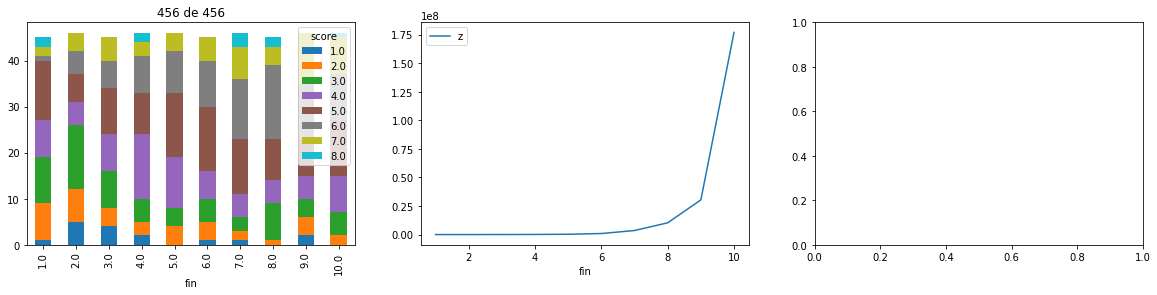

In [487]:
def createAttrConfig(desc):
    return [
            Dropdown(description=desc, options=numericCols2),
            widgets.ToggleButtons(
                options=['<<', '>>'],
                description='Impacto:'
            )
    ]

numericCols2 = [''] + numericCols;
varConfig = [createAttrConfig('x'+str(i+1)) for i in range(5)];

zvar = Dropdown(description='impact', options=numericCols[1:]);
zrange  = IntSlider(min=0, max=50, step=1,continuous_update=False,description='%Massa:');

ngroups = IntSlider(min=2, max=10, step=1,value=10,continuous_update=False,description='N Impacts');
ngroupsScore = IntSlider(min=2, max=10, step=1,value=10,continuous_update=False,description='N Scores');
methodType = Dropdown(description='Method', options=["Rank","Mahalanobis","KMeans","AffinityPropagation","AgglomerativeClustering"]);


ui = widgets.VBox([widgets.HBox(drops), widgets.HBox([zvar,zrange,ngroups,ngroupsScore])]);
ui = widgets.Accordion()
ui.children = [
    widgets.VBox([widgets.HBox(x) for x in varConfig]),
    widgets.VBox([
        widgets.HBox([zvar,zrange,ngroups]),
        widgets.HBox([ngroupsScore,methodType])
    ])
]
ui.set_title(0, 'Variáveis');
ui.set_title(1, 'Configuração Score');

comps ={d[0].description:d[0] for d in varConfig};
comps.update({
    'size':zvar,
    'mass':zrange ,
    'ngroups':ngroups,
    'ngroupsScore':ngroupsScore,
    'method':methodType
})
out = widgets.interactive_output(makePOI2, comps)
display(ui, out)

In [ ]:
    grid = sns.FacetGrid(att, col="walk", hue="score", palette="tab20c", col_wrap=4, height=1.5)
    grid.map(plt.plot, "step", "position", marker="o",)

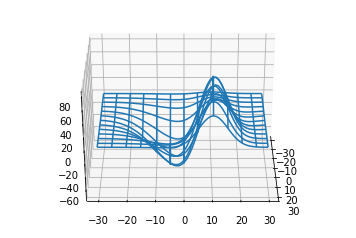

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [446]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1);
ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5);

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle);
    plt.draw();
    plt.pause(.001);